In [208]:
from enum import Enum
import cv2
from matplotlib import pyplot as plt
import numpy as np
import json

In [209]:
INPUT_DIR = "./data/input/test-cp.jpg"
LABEL_JSON = "./data/label.json"
OUTPUT_DIR = "./data/output"

class Field:
    def __init__(self, img: np.ndarray, rect: tuple[int, int, int, int] = (0, 0, 0, 0)):
        self.img = img
        self.rect = rect

    def __repr__(self):
        return f"{self.rect} -> {self.img}"


class FieldName(Enum):
    exam_title = "exam_title"
    student_name = "student_name"
    date = "date"
    exam_key = "exam_key"
    student_id = "student_id"
    answers = "answers"
    


In [210]:
import os


def load_image(image_path):
    print(os.path.exists(image_path))
    return cv2.imread(image_path)

def show_image(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def save_image(image, image_name, output_dir=OUTPUT_DIR):
    cv2.imwrite(f"{output_dir}/{image_name}", image)

True


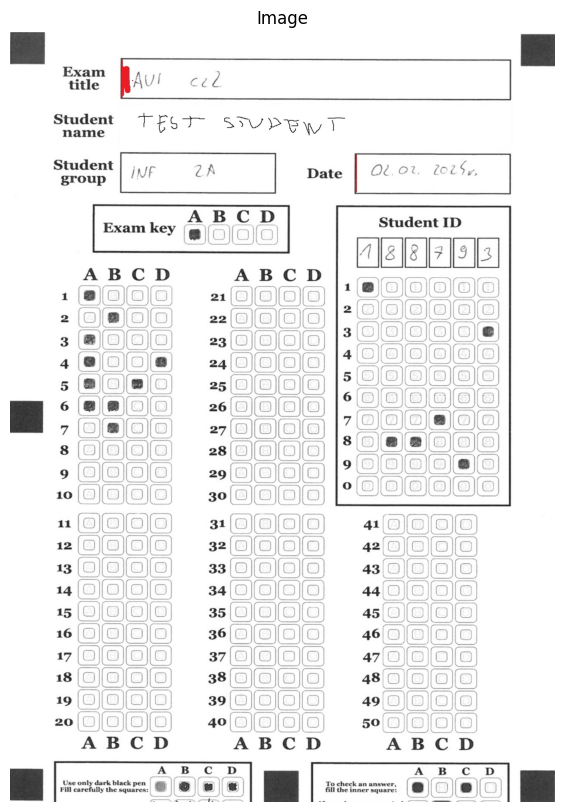

In [211]:

image = load_image(INPUT_DIR)
show_image(image)


In [212]:
def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

def map_json_to_field_coordinates(json_data):
    field_coordinates = {}
    for field, coordinates_list in json_data["fields"].items():
        if field in FieldName.__members__:
            field_enum = FieldName[field]
            field_coordinates[field_enum] = [
                (coord["x"], coord["y"], coord["width"], coord["height"]) for coord in coordinates_list
            ]
    return field_coordinates


json_data = load_json(LABEL_JSON)
FIELD_COORDINATES = map_json_to_field_coordinates(json_data)
FIELD_COORDINATES

{<FieldName.student_id: 'student_id'>: [(1477, 786, 811, 1379)],
 <FieldName.exam_key: 'exam_key'>: [(790, 870, 440, 100)],
 <FieldName.date: 'date'>: [(1575, 565, 695, 164)],
 <FieldName.exam_title: 'exam_title'>: [(508, 133, 1763, 164)],
 <FieldName.student_name: 'student_name'>: [(508, 353, 1763, 164)],
 <FieldName.answers: 'answers'>: [(305, 1150, 440, 1010),
  (305, 2185, 440, 1010),
  (998, 1150, 440, 1010),
  (998, 2185, 440, 1010),
  (1690, 2190, 440, 1010)]}

In [213]:

def crop_image(image, coordinates):
    x, y, w, h = coordinates
    print(f"X: {x}, Y: {y}, W: {w}, H: {h}")
    return image[y:y+h, x:x+w]

def extract_fields_from_coordinates(image, field_coordinates):
    fields = {}
    for field_name, coordinates in field_coordinates.items():
        for i, coordinate in enumerate(coordinates):
            field_image = crop_image(image, coordinate)
            fields[f"{field_name}_{i}"] = field_image
            
    return fields

fields = extract_fields_from_coordinates(image, FIELD_COORDINATES)

X: 1477, Y: 786, W: 811, H: 1379
X: 790, Y: 870, W: 440, H: 100
X: 1575, Y: 565, W: 695, H: 164
X: 508, Y: 133, W: 1763, H: 164
X: 508, Y: 353, W: 1763, H: 164
X: 305, Y: 1150, W: 440, H: 1010
X: 305, Y: 2185, W: 440, H: 1010
X: 998, Y: 1150, W: 440, H: 1010
X: 998, Y: 2185, W: 440, H: 1010
X: 1690, Y: 2190, W: 440, H: 1010


In [214]:

def answer_fields(fields):
    PADDING_PX = 2
    TARGET_SIZE = (90, 90)
    answers = []
    idx = 0
    for field_name, field_image in fields.items():
        if FieldName.answers.name not in field_name:
            print(f"Skipping {field_name}")
            continue
            
        answer_array = np.zeros((10, 4, 90, 90, 3), dtype=np.uint8) 
        print(f"Processing {field_name}, shape: {field_image.shape}")
    
        number_of_rows = 10
        answer_row_height = field_image.shape[0] // number_of_rows
    
        # save_image(field_image, f"{field_name}.jpg")
    
        
        for i in range(number_of_rows):
            start_x = max(0, i*answer_row_height)
            end_x = min((i+1)*answer_row_height + PADDING_PX, field_image.shape[0])
            answer_row = field_image[start_x:end_x, :]
            # print(f"Answer Row {i}, shape: {answer_row.shape}, start_x: {start_x}, end_x: {end_x}")
            # save_image(answer_row, f"{field_name}_{i}_answer_row.jpg")
            
            number_of_options = 4
            answer_option_height = answer_row.shape[0] 
            answer_option_width = answer_row.shape[1] // number_of_options
            # print(f"Answer Option Height: {answer_option_height}, Answer Option Width: {answer_option_width}")
            for j in range(number_of_options):
                start_y = j * answer_option_width
                end_y = start_y + answer_option_width
                answer_option = answer_row[:answer_row.shape[0], start_y:end_y]
                # print(f"Answer Option {j}, shape: {answer_option.shape}, start_y: {start_y}, end_y: {end_y}")
                # show_image(answer_option, f"{field_name}_answer_option_{i}_{j}.jpg")
                
                # print(f"Resizing to {TARGET_SIZE}")
                resized_answer_option = cv2.resize(answer_option, TARGET_SIZE)
                answer_array[i, j] = resized_answer_option
                # show_image(resized_answer_option)
                # save_image(answer_option, f"{field_name}_answer_option_{i}_{j}.jpg")
        
            
        answers.append(Field(answer_array, FIELD_COORDINATES[FieldName.answers][idx]))
        idx += 1
        
    return answers
def convert_to_black_and_white(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bw_image = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5
    )
    kernel = np.ones((1, 1), np.uint8)
    denoised_image = cv2.morphologyEx(bw_image, cv2.MORPH_OPEN, kernel)

    final_image = cv2.fastNlMeansDenoising(denoised_image, h=30)

    return final_image


def text_extractor(fields):
    student_name = []
    required_keywords = [FieldName.student_name.name, FieldName.exam_title.name, FieldName.date.name]
    for field_name, field_image in fields.items():
        if not any(keyword in field_name for keyword in required_keywords):
            print(f"Skipping {field_name}")
            continue
        
        
        bw_image = convert_to_black_and_white(field_image)
        student_name.append(Field(bw_image, FIELD_COORDINATES[FieldName.student_name][0]))
        
        show_image(bw_image, field_name)
        
    return student_name

def group_extracted_fields(fields):
    extracted_fields = {}
    for field_name, field_image in fields.items():
        if not FieldName.exam_key.name in field_name:
            continue

        extracted_fields[field_name] = field_image
        
        show_image(field_image, field_name)
    return extracted_fields

def student_id_extractor(fields):
    student_id = []
    for field_name, field_image in fields.items():
        if not FieldName.student_id.name in field_name:
            print(f"Skipping {field_name}")
            continue
        
        
        show_image(field_image, field_name)
        
    return student_id


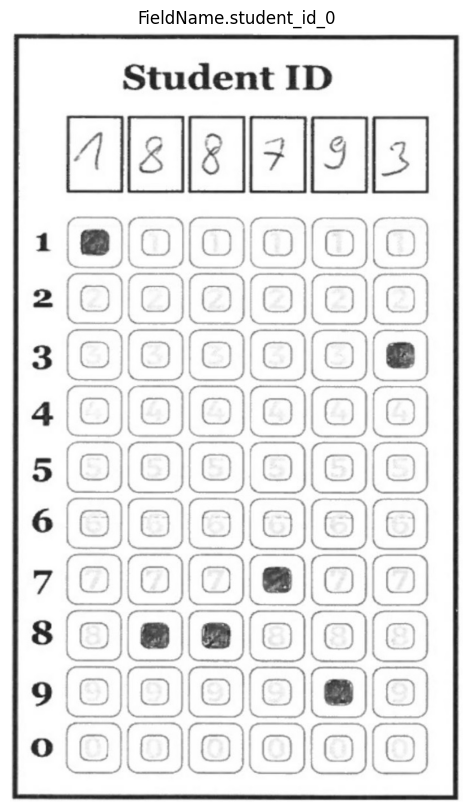

Skipping FieldName.exam_key_0
Skipping FieldName.date_0
Skipping FieldName.exam_title_0
Skipping FieldName.student_name_0
Skipping FieldName.answers_0
Skipping FieldName.answers_1
Skipping FieldName.answers_2
Skipping FieldName.answers_3
Skipping FieldName.answers_4


In [215]:
# answers = answer_fields(fields)
# student_names = text_extractor(fields)
# exam_keys = group_extracted_fields(fields)
student_ids = student_id_extractor(fields)